In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy)
"""
# %matplotlib widget
import pandas as pd
import ampiimts
import os

In [ ]:
folder = '../../dataset'
pds = []

with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv'):
            # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
            pds.append(pd.read_csv(folder+'/'+entry.name))

../../dataset/nyc_taxi.csv
../../dataset/ec2_request_latency_system_failure.csv
../../dataset/cpu_utilization_asg_misconfiguration.csv
../../dataset/occupancy_6005.csv
../../dataset/art_daily_jumpsup.csv
../../dataset/ambient_temperature_system_failure.csv


In [ ]:
# get original dataframe
for df in pds:
    df_normalize = ampiimts.pre_processed(df)
    result = ampiimts.matrix_profile(df_normalize, max_matches=30)
    ampiimts.plot_patterns_and_discords(ampiimts.interpolate(df), result)

Best consensus window size(s): [(10, '0 days 05:00:00', np.float32(0.013230133), np.float64(0.017)), (11, '0 days 05:30:00', np.float32(0.014057767), np.float64(0.0085)), (12, '0 days 06:00:00', np.float32(0.015478293), np.float64(0.003))]
Best window sizes (hours): 0 days 05:00:00, 0 days 05:30:00, 0 days 06:00:00


Best consensus window size(s): [(3483, '12 days 02:15:00', np.float32(0.019266222), np.float64(0.0)), (3351, '11 days 15:15:00', np.float32(0.019479668), np.float64(0.0)), (3620, '12 days 13:40:00', np.float32(0.019658042), np.float64(0.0))]
Best window sizes (hours): 12 days 02:15:00, 11 days 15:15:00, 12 days 13:40:00


/home/guillaume/swt_package/.env_swt/lib/python3.12/site-packages/stumpy/aamp_motifs.py:308: UserWarning: No motifs were found. You may consider increasing the `cutoff` (e.g., cutoff=2777.181414182775) and/or increasing the `max_distance `(e.g., max_distance=np.inf).
  warnings.warn(msg)


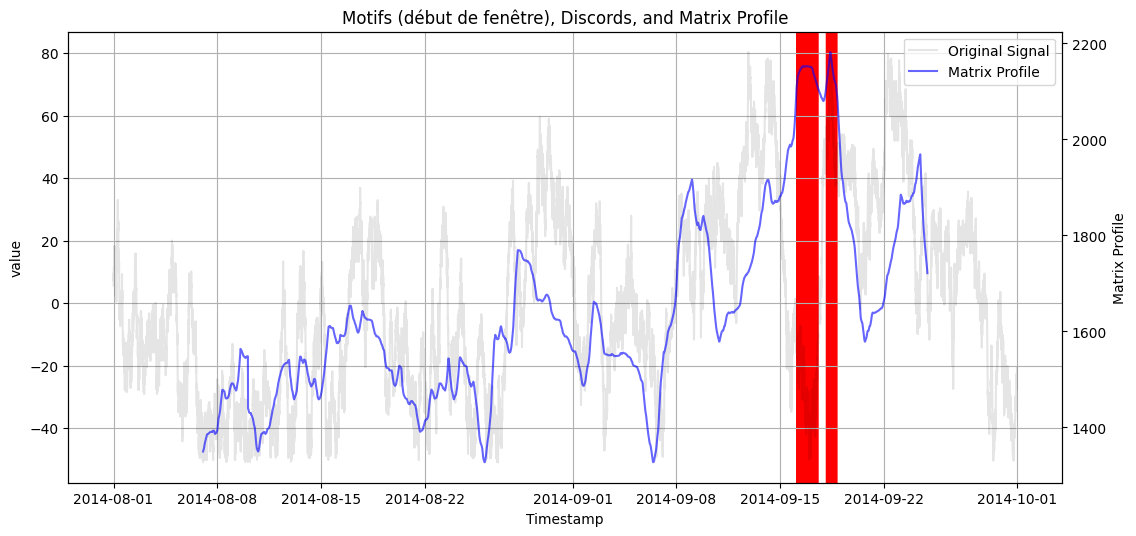

In [ ]:
# get original dataframe
df = pd.read_csv('../../dataset/pollution/pollution_sensor_1.csv')
df = df[['timestamp','ozone']].rename(columns={"ozone": "value"})
df_normalize = ampiimts.pre_processed(df)
result = ampiimts.matrix_profile(df_normalize, max_matches=30)

ampiimts.plot_patterns_and_discords(df_normalize, result)